In [131]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import matplotlib.pyplot as plt

# Import Dataset

In [132]:
data = pd.read_excel('/content/BA_AirlineReviews_CL_excel.xlsx',header=0)
data.head()

,id,Satisfaction,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,Very Dissatisfied,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,2023-11-01,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,Neutral,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,2023-11-01,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,Enthusiastic,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,2023-11-01,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,Very Dissatisfied,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,2022-12-01,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,4,Very Dissatisfied,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,2023-11-01,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0


In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     3701 non-null   int64         
 1   Satisfaction           3701 non-null   object        
 2   ReviewHeader           3701 non-null   object        
 3   Name                   3701 non-null   object        
 4   Datetime               3701 non-null   object        
 5   VerifiedReview         3701 non-null   bool          
 6   ReviewBody             3701 non-null   object        
 7   TypeOfTraveller        2930 non-null   object        
 8   SeatType               3699 non-null   object        
 9   Route                  2926 non-null   object        
 10  DateFlown              2923 non-null   datetime64[ns]
 11  SeatComfort            3585 non-null   float64       
 12  CabinStaffService      3574 non-null   float64       
 13  Gro

# Preprocessing the data

**Handling numerical missing value**

In [134]:
from sklearn.impute import KNNImputer

numeric_missing_col = data.columns[(data.isnull().any()) & (data.dtypes != 'object')].to_list()

impNumeric = KNNImputer(n_neighbors=5)
for col in numeric_missing_col:
    numeric = data[[col]].values
    impNumeric = impNumeric.fit(numeric)
    numeric = impNumeric.transform(numeric)
    numeric = numeric.round()
    data[col] = numeric

data.isnull().sum()

id                          0
Satisfaction                0
ReviewHeader                0
Name                        0
Datetime                    0
VerifiedReview              0
ReviewBody                  0
TypeOfTraveller           771
SeatType                    2
Route                     775
DateFlown                   0
SeatComfort                 0
CabinStaffService           0
GroundService               0
ValueForMoney               0
Recommended                 0
Aircraft                 1779
Food&Beverages              0
InflightEntertainment       0
Wifi&Connectivity           0
dtype: int64

**Handling nominal missing value**

In [135]:
nominal_missing_col = data.columns[(data.isnull().any()) & (data.dtypes == 'object')].to_list()
for col in nominal_missing_col:
    data[col].fillna("Unknown", inplace=True)

data.isnull().sum()

id                       0
Satisfaction             0
ReviewHeader             0
Name                     0
Datetime                 0
VerifiedReview           0
ReviewBody               0
TypeOfTraveller          0
SeatType                 0
Route                    0
DateFlown                0
SeatComfort              0
CabinStaffService        0
GroundService            0
ValueForMoney            0
Recommended              0
Aircraft                 0
Food&Beverages           0
InflightEntertainment    0
Wifi&Connectivity        0
dtype: int64

**Features and Label Encoding**

1. Categorical data encoding

In [136]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
categorical_col = ['TypeOfTraveller', 'SeatType']
for col in categorical_col:
    encoded_data = encoder.fit_transform(data[[col]])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([col]))
    data = pd.concat([data, encoded_df], axis=1)
    data = data.drop([col], axis=1)

2. Binary data encoding

In [137]:
from sklearn.preprocessing import LabelEncoder

lbenc = LabelEncoder()
for i in data.columns.values:
    if (data[i].dtypes == "object" or data[i].dtypes == "bool") and i != "Satisfaction":
        data[i] = lbenc.fit_transform(data[i].astype(str))


3. Label encoding

In [138]:
from sklearn.preprocessing import OrdinalEncoder

satisfaction_order = [
    "Very Dissatisfied",
    "Dissatisfied",
    "Neutral",
    "Satisfied",
    "Very Satisfied",
    "Enthusiastic",
    "Extremely Satisfied",
    "Delighted",
    "Evangelist",
    "Advocate"
]

ordinal_enc = OrdinalEncoder(categories=[satisfaction_order])
data["Satisfaction"] = ordinal_enc.fit_transform(data[["Satisfaction"]])

In [139]:
data.head()

,id,Satisfaction,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,Route,DateFlown,SeatComfort,...,TypeOfTraveller_Business,TypeOfTraveller_Couple Leisure,TypeOfTraveller_Family Leisure,TypeOfTraveller_Solo Leisure,TypeOfTraveller_Unknown,SeatType_Business Class,SeatType_Economy Class,SeatType_First Class,SeatType_Premium Economy,SeatType_Unknown
0,0,0.0,483,1590,595,1,25,1044,1.698797e+18,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,2.0,1128,254,595,1,1649,143,1.698797e+18,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,5.0,264,1660,406,0,372,824,1.698797e+18,3.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,0.0,37,2009,406,1,28,946,1.669853e+18,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,0.0,222,1013,295,0,3603,976,1.698797e+18,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [140]:
data.describe()

,id,Satisfaction,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,Route,DateFlown,SeatComfort,...,TypeOfTraveller_Business,TypeOfTraveller_Couple Leisure,TypeOfTraveller_Family Leisure,TypeOfTraveller_Solo Leisure,TypeOfTraveller_Unknown,SeatType_Business Class,SeatType_Economy Class,SeatType_First Class,SeatType_Premium Economy,SeatType_Unknown
count,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3.701000e+03,3701.000000,...,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.00000,3701.000000,3701.000000,3701.000000
mean,1850.000000,3.627668,1665.487166,1396.319643,905.066739,0.311537,1845.307755,924.593083,-7.329317e+17,2.879222,...,0.173196,0.270197,0.107539,0.240746,0.208322,0.323696,0.52067,0.057552,0.097541,0.000540
std,1068.531001,3.094761,869.403991,838.782534,527.062164,0.463184,1065.214398,468.600891,4.381454e+18,1.340735,...,0.378468,0.444122,0.309839,0.427594,0.406163,0.467949,0.49964,0.232926,0.296733,0.023243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.223372e+18,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,925.000000,1.000000,897.000000,655.000000,457.000000,0.000000,923.000000,563.000000,1.438387e+18,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1850.000000,3.000000,1804.000000,1354.000000,888.000000,0.000000,1847.000000,962.000000,1.483229e+18,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
75%,2775.000000,6.000000,2609.000000,2136.000000,1373.000000,1.000000,2767.000000,1454.000000,1.551398e+18,4.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000
max,3700.000000,9.000000,2684.000000,2901.000000,1819.000000,1.000000,3691.000000,1542.000000,1.698797e+18,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


**Removing unwanted columns**

In [141]:
data.drop(['id', 'Name', 'ReviewHeader', 'ReviewBody', 'Route', 'Aircraft', 'DateFlown', 'Datetime'], inplace=True, axis = 1)
data.columns.to_list()

['Satisfaction',
 'VerifiedReview',
 'SeatComfort',
 'CabinStaffService',
 'GroundService',
 'ValueForMoney',
 'Recommended',
 'Food&Beverages',
 'InflightEntertainment',
 'Wifi&Connectivity',
 'TypeOfTraveller_Business',
 'TypeOfTraveller_Couple Leisure',
 'TypeOfTraveller_Family Leisure',
 'TypeOfTraveller_Solo Leisure',
 'TypeOfTraveller_Unknown',
 'SeatType_Business Class',
 'SeatType_Economy Class',
 'SeatType_First Class',
 'SeatType_Premium Economy',
 'SeatType_Unknown']

**Spliting the data into train and test**

In [142]:
from sklearn.model_selection import train_test_split

features = data.drop(['Satisfaction'], axis=1)
label = data['Satisfaction']

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.5, random_state=42, stratify=label)

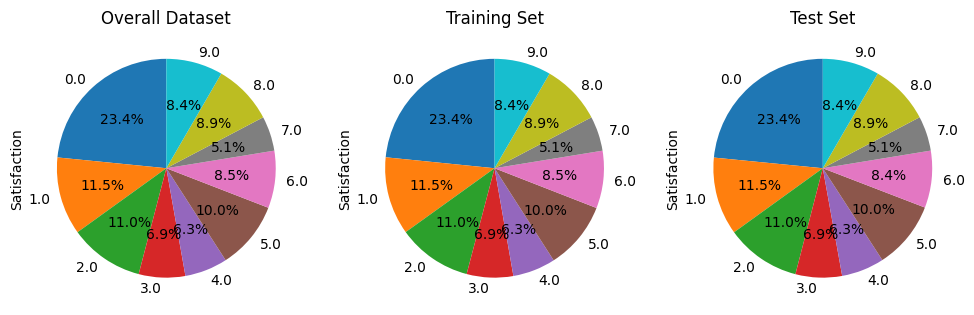

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

s_train = pd.DataFrame(y_train, columns=['Satisfaction'])
s_test = pd.DataFrame(y_test, columns=['Satisfaction'])

sorted_train = s_train['Satisfaction'].value_counts().sort_index()
sorted_test = s_test['Satisfaction'].value_counts().sort_index()
sorted_data = data['Satisfaction'].value_counts().sort_index()

# Create a pie chart for the overall dataset
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 2)
plt.title('Training Set')
sorted_train.plot.pie(autopct='%1.1f%%', startangle=90)

plt.subplot(1, 3, 3)
plt.title('Test Set')
sorted_test.plot.pie(autopct='%1.1f%%', startangle=90)

plt.subplot(1, 3, 1)
plt.title('Overall Dataset')
sorted_data.plot.pie(autopct='%1.1f%%', startangle=90)

plt.show()

**Feature Scaling**

In [144]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

**Feature Correlation**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,-0.060592,-0.045706,-0.048202,-0.095571,-0.081044,0.008552,0.070602,0.070833,0.077706,0.043317,0.058301,0.178598,-0.353053,0.020718,0.022286,-0.057312,-0.025238,-0.016172
1,-0.060592,1.000000,0.613065,0.478298,0.683989,0.655011,0.581746,0.463741,0.253906,-0.133077,-0.071887,-0.019905,0.085375,0.126561,0.021197,-0.106987,0.152893,0.030903,-0.032341
2,-0.045706,0.613065,1.000000,0.463448,0.649277,0.657046,0.660545,0.369988,0.235324,-0.145609,-0.048304,-0.012475,0.067211,0.125988,0.111667,-0.138238,0.097009,-0.021414,0.012469
3,-0.048202,0.478298,0.463448,1.000000,0.590021,0.553329,0.380810,0.249060,0.230409,-0.148049,-0.015574,-0.014885,0.103088,0.056037,0.073976,-0.101515,0.032971,0.032809,-0.033897
4,-0.095571,0.683989,0.649277,0.590021,1.000000,0.803380,0.638749,0.403094,0.236271,-0.194993,-0.075901,-0.040602,0.083018,0.206417,0.042096,-0.068237,0.057280,0.006025,-0.026836
5,-0.081044,0.655011,0.657046,0.553329,0.803380,1.000000,0.657007,0.386118,0.228734,-0.185215,-0.068066,-0.019963,0.072341,0.184570,0.085305,-0.102353,0.038865,0.009385,-0.019138
6,0.008552,0.581746,0.660545,0.380810,0.638749,0.657007,1.000000,0.454650,0.254216,-0.131042,-0.057194,-0.035401,0.066229,0.140529,0.119465,-0.146995,0.092652,-0.014594,0.004874
7,0.070602,0.463741,0.369988,0.249060,0.403094,0.386118,0.454650,1.000000,0.309410,-0.080460,0.036725,0.016366,0.073711,-0.056323,0.024743,-0.040232,0.057812,-0.016290,-0.014716
8,0.070833,0.253906,0.235324,0.230409,0.236271,0.228734,0.254216,0.309410,1.000000,-0.058464,0.000389,0.028611,0.004317,0.027657,0.077226,-0.077504,-0.004563,0.012930,0.001257
9,0.077706,-0.133077,-0.145609,-0.148049,-0.194993,-0.185215,-0.131042,-0.080460,-0.058464,1.000000,-0.277200,-0.154156,-0.258714,-0.231846,0.141255,-0.110704,-0.018864,-0.021710,-0.010535


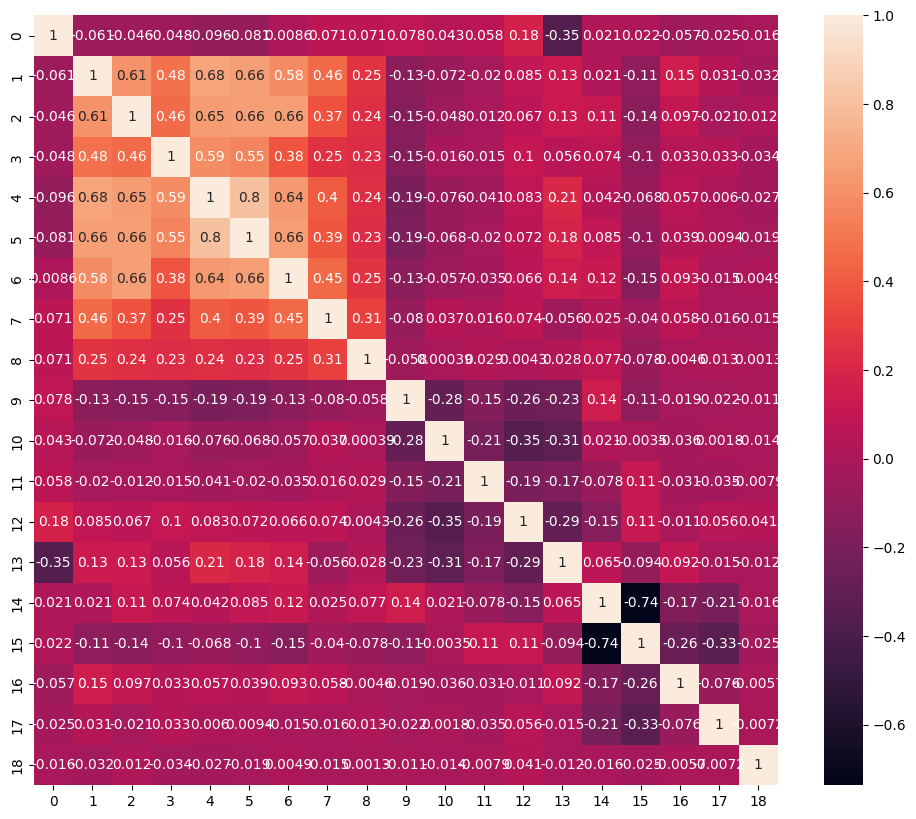

In [145]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

correlation_matrix = pd.DataFrame(x_train).corr()
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True ,ax=ax)
correlation_matrix

In [146]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = pd.DataFrame(dataset, columns=col).corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [147]:
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop)

x_train = x_train.drop(x_train.columns[to_drop], axis=1)
x_test = x_test.drop(x_test.columns[to_drop], axis=1)

[]


# Developing the MultiLayer Perceptron Model

In [148]:
import tensorflow as tf

class MLPClassifier:
    def __init__(self, input_shape, label_class, learning_rate=0.001, activation_function='sigmoid'):
        self.input_shape = input_shape
        self.label_class = label_class
        self.activation_function = activation_function
        tf.keras.utils.set_random_seed(42)

        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Dense(128, input_shape=[self.input_shape], activation=self.activation_function))
        self.model.add(tf.keras.layers.Dense(64, activation=self.activation_function))
        self.model.add(tf.keras.layers.Dense(32, activation=self.activation_function))

        # self.model.add(tf.keras.layers.Dense(128, input_shape=[self.input_shape], activation=self.activation_function, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        # self.model.add(tf.keras.layers.BatchNormalization())
        # self.model.add(tf.keras.layers.Dropout(0.5))
        # self.model.add(tf.keras.layers.Dense(64, activation=self.activation_function, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        # self.model.add(tf.keras.layers.BatchNormalization())
        # self.model.add(tf.keras.layers.Dropout(0.5))
        # self.model.add(tf.keras.layers.Dense(32, activation=self.activation_function, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        # self.model.add(tf.keras.layers.BatchNormalization())
        # self.model.add(tf.keras.layers.Dropout(0.5))

        self.model.add(tf.keras.layers.Dense(self.label_class, activation=self.activation_function))

        # Compile the model
        # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(self.learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True)
        # self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.learning_rate = learning_rate
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def train(self, x_train, y_train, x_val=None, y_val=None, epochs=100, batch_size=32, callback=None):
        # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

        # if x_val is not None and y_val is not None:
        #     history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[early_stopping, callback] if callback is not None else [early_stopping])
        # else:
        #     history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, callback] if callback is not None else [early_stopping])
        if x_val is not None and y_val is not None:
            history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[callback] if callback is not None else [])
        else:
            history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callback] if callback is not None else [])

        return history


    def get_accuracy(self, x_test, y_test):
        accuracy = self.model.evaluate(x_test, y_test)
        return accuracy[1]


    def summary(self):
        self.model.summary()

    def set_history(self):
        class LossHistoryCallback(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs=None):
                self.losses = []
                self.accuracies = []
                self.val_losses = []
                self.val_accuracies = []

            def on_epoch_end(self, epoch, logs=None):
                self.losses.append(logs.get('loss'))
                self.accuracies.append(logs.get('accuracy'))
                self.val_losses.append(logs.get('val_loss'))
                self.val_accuracies.append(logs.get('val_accuracy'))

        history = LossHistoryCallback()
        return history

    def plot_loss_history(self, losses, val_losses=None):
        plt.plot(losses, label='Training Loss')
        if val_losses is not None:
            plt.plot(val_losses, label='Validation Loss')
        plt.title('Loss History')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_accuracy_history(self, accuracies, val_accuracies=None):
        plt.plot(accuracies, label='Training Accuracy')
        if val_accuracies is not None:
            plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Accuracy History')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return np.argmax(predictions, axis=1)

    def summary(self):
        self.model.summary()

Epoch 1/100
58/58 [==============================] - 1s 4ms/step - loss: 2.2297 - accuracy: 0.2319
Epoch 2/100
58/58 [==============================] - 0s 4ms/step - loss: 2.1145 - accuracy: 0.2503
Epoch 3/100
58/58 [==============================] - 0s 3ms/step - loss: 1.9087 - accuracy: 0.3227
Epoch 4/100
58/58 [==============================] - 0s 2ms/step - loss: 1.7454 - accuracy: 0.3405
Epoch 5/100
58/58 [==============================] - 0s 2ms/step - loss: 1.6524 - accuracy: 0.3422
Epoch 6/100
58/58 [==============================] - 0s 3ms/step - loss: 1.5944 - accuracy: 0.3573
Epoch 7/100
58/58 [==============================] - 0s 2ms/step - loss: 1.5508 - accuracy: 0.3816
Epoch 8/100
58/58 [==============================] - 0s 2ms/step - loss: 1.5113 - accuracy: 0.4157
Epoch 9/100
58/58 [==============================] - 0s 2ms/step - loss: 1.4772 - accuracy: 0.4211
Epoch 10/100
58/58 [==============================] - 0s 2ms/step - loss: 1.4489 - accuracy: 0.4357
Epoch 11/

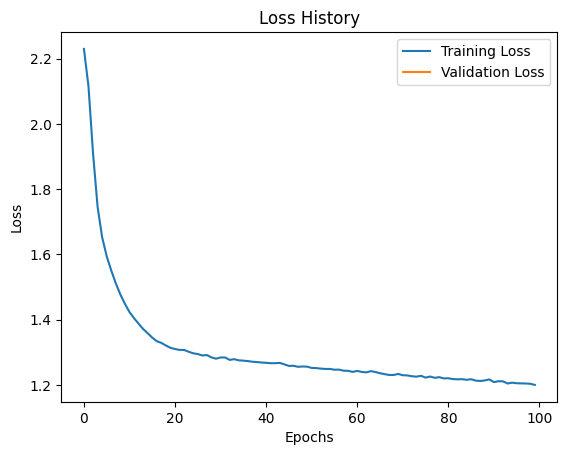

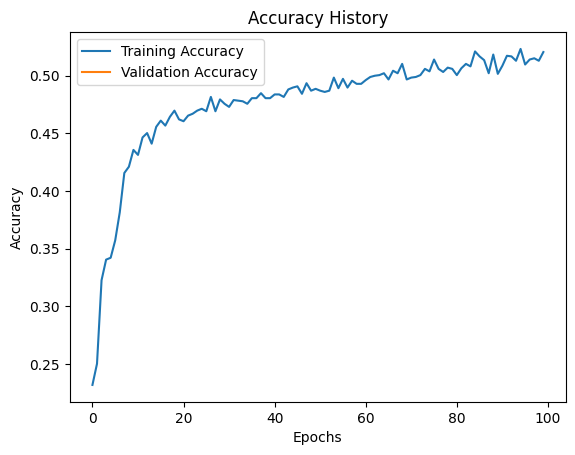

58/58 [==============================] - 0s 2ms/step - loss: 1.1900 - accuracy: 0.5130

Test Accuracy	: 0.45218801498413086
Train Accuracy	: 0.5129729509353638


In [149]:
model = MLPClassifier(x_train.shape[1], label.unique().shape[0], learning_rate=0.001, activation_function='sigmoid')

history = model.set_history()
model.train(x_train, y_train, epochs=100, callback=history, batch_size=32)

model.plot_loss_history(history.losses, history.val_losses)
model.plot_accuracy_history(history.accuracies, history.val_accuracies)
print(f'\nTest Accuracy\t: {model.get_accuracy(x_test, y_test)}\nTrain Accuracy\t: {model.get_accuracy(x_train, y_train)}')

## Classification Report

In [150]:
def plot_cm(matrix, title):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=sns.cubehelix_palette(as_cmap=True))

    ax.set_title(f'Confusion Matrix {title}', pad=10);
    plt.show()

**Test Predictions**

58/58 [==============================] - 0s 2ms/step


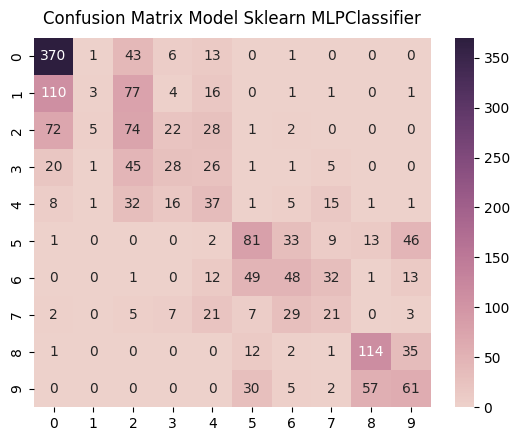

,precision,recall,f1-score,support
0.0,0.633562,0.852535,0.726916,434.000000
1.0,0.272727,0.014085,0.026786,213.000000
2.0,0.267148,0.362745,0.307692,204.000000
3.0,0.337349,0.220472,0.266667,127.000000
4.0,0.238710,0.316239,0.272059,117.000000
5.0,0.445055,0.437838,0.441417,185.000000
6.0,0.377953,0.307692,0.339223,156.000000
7.0,0.244186,0.221053,0.232044,95.000000
8.0,0.612903,0.690909,0.649573,165.000000
9.0,0.381250,0.393548,0.387302,155.000000


In [151]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_test)

confusion_matrix_result = confusion_matrix(y_test, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_test, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

**Train Predictions**

58/58 [==============================] - 0s 2ms/step


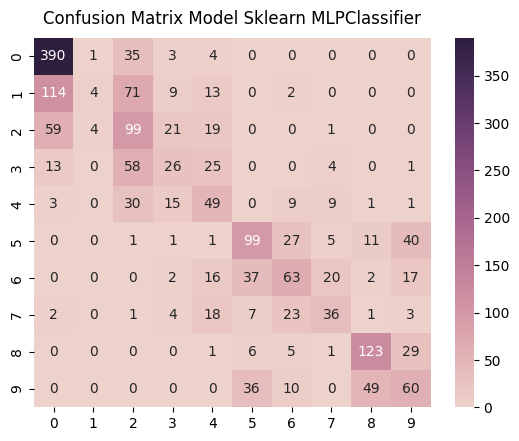

,precision,recall,f1-score,support
0.0,0.671256,0.900693,0.769231,433.000000
1.0,0.444444,0.018779,0.036036,213.000000
2.0,0.335593,0.487685,0.397590,203.000000
3.0,0.320988,0.204724,0.250000,127.000000
4.0,0.335616,0.418803,0.372624,117.000000
5.0,0.535135,0.535135,0.535135,185.000000
6.0,0.453237,0.401274,0.425676,157.000000
7.0,0.473684,0.378947,0.421053,95.000000
8.0,0.657754,0.745455,0.698864,165.000000
9.0,0.397351,0.387097,0.392157,155.000000


In [152]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_train)

confusion_matrix_result = confusion_matrix(y_train, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_train, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

# Experiments

In [153]:
import tensorflow as tf

class MLPClassifier:
    def __init__(self, input_shape, label_class, learning_rate=0.001, activation_function='sigmoid'):
        self.input_shape = input_shape
        self.label_class = label_class
        self.activation_function = activation_function
        tf.keras.utils.set_random_seed(42)

        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Dense(128, input_shape=[self.input_shape], activation=self.activation_function))
        self.model.add(tf.keras.layers.Dense(64, activation=self.activation_function))
        self.model.add(tf.keras.layers.Dense(32, activation=self.activation_function))

        # self.model.add(tf.keras.layers.Dense(128, input_shape=[self.input_shape], activation=self.activation_function, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        # self.model.add(tf.keras.layers.BatchNormalization())
        # self.model.add(tf.keras.layers.Dropout(0.5))
        # self.model.add(tf.keras.layers.Dense(64, activation=self.activation_function, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        # self.model.add(tf.keras.layers.BatchNormalization())
        # self.model.add(tf.keras.layers.Dropout(0.5))
        # self.model.add(tf.keras.layers.Dense(32, activation=self.activation_function, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        # self.model.add(tf.keras.layers.BatchNormalization())
        # self.model.add(tf.keras.layers.Dropout(0.5))

        self.model.add(tf.keras.layers.Dense(self.label_class, activation='softmax'))

        # Compile the model
        # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(self.learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True)
        # self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.learning_rate = learning_rate
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def train(self, x_train, y_train, x_val=None, y_val=None, epochs=100, batch_size=32, callback=None):
        # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

        # if x_val is not None and y_val is not None:
        #     history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[early_stopping, callback] if callback is not None else [early_stopping])
        # else:
        #     history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, callback] if callback is not None else [early_stopping])
        if x_val is not None and y_val is not None:
            history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[callback] if callback is not None else [])
        else:
            history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callback] if callback is not None else [])

        return history

    def get_accuracy(self, x_test, y_test):
        accuracy = self.model.evaluate(x_test, y_test)
        return accuracy[1]


    def summary(self):
        self.model.summary()

    def set_history(self):
        class LossHistoryCallback(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs=None):
                self.losses = []
                self.accuracies = []
                self.val_losses = []
                self.val_accuracies = []

            def on_epoch_end(self, epoch, logs=None):
                self.losses.append(logs.get('loss'))
                self.accuracies.append(logs.get('accuracy'))
                self.val_losses.append(logs.get('val_loss'))
                self.val_accuracies.append(logs.get('val_accuracy'))

        history = LossHistoryCallback()
        return history

    def plot_loss_history(self, losses, val_losses=None):
        plt.plot(losses, label='Training Loss')
        if val_losses is not None:
            plt.plot(val_losses, label='Validation Loss')
        plt.title('Loss History')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_accuracy_history(self, accuracies, val_accuracies=None):
        plt.plot(accuracies, label='Training Accuracy')
        if val_accuracies is not None:
            plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Accuracy History')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return np.argmax(predictions, axis=1)

    def summary(self):
        self.model.summary()

## Epoch 10

Epoch 1/10
58/58 [==============================] - 1s 2ms/step - loss: 1.9794 - accuracy: 0.3032
Epoch 2/10
58/58 [==============================] - 0s 2ms/step - loss: 1.5596 - accuracy: 0.3757
Epoch 3/10
58/58 [==============================] - 0s 2ms/step - loss: 1.4159 - accuracy: 0.4292
Epoch 4/10
58/58 [==============================] - 0s 2ms/step - loss: 1.3396 - accuracy: 0.4746
Epoch 5/10
58/58 [==============================] - 0s 2ms/step - loss: 1.2776 - accuracy: 0.4903
Epoch 6/10
58/58 [==============================] - 0s 2ms/step - loss: 1.2539 - accuracy: 0.5059
Epoch 7/10
58/58 [==============================] - 0s 2ms/step - loss: 1.2306 - accuracy: 0.4951
Epoch 8/10
58/58 [==============================] - 0s 2ms/step - loss: 1.2100 - accuracy: 0.5222
Epoch 9/10
58/58 [==============================] - 0s 2ms/step - loss: 1.1961 - accuracy: 0.5189
Epoch 10/10
58/58 [==============================] - 0s 2ms/step - loss: 1.1801 - accuracy: 0.5308


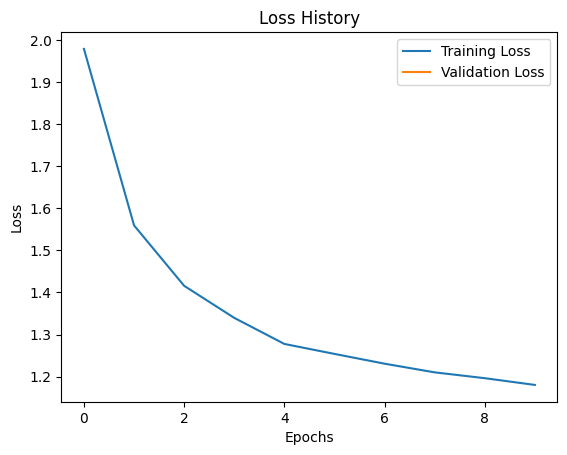

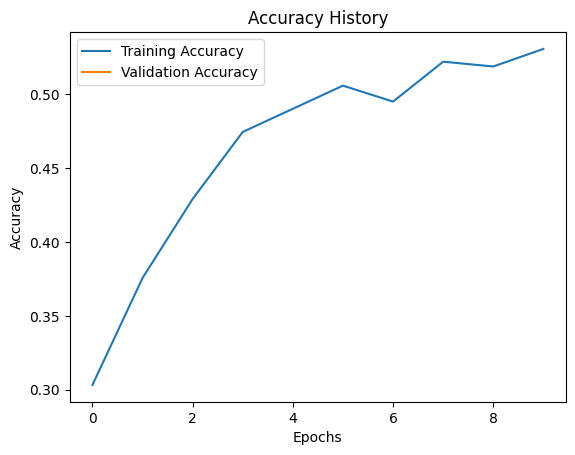

58/58 [==============================] - 0s 2ms/step - loss: 1.1321 - accuracy: 0.5465

Test Accuracy	: 0.4548892378807068
Train Accuracy	: 0.546486496925354


In [154]:
model = MLPClassifier(x_train.shape[1], label.unique().shape[0], learning_rate=0.001, activation_function='relu')

history = model.set_history()
model.train(x_train, y_train, epochs=10, callback=history, batch_size=32)

model.plot_loss_history(history.losses, history.val_losses)
model.plot_accuracy_history(history.accuracies, history.val_accuracies)
print(f'\nTest Accuracy\t: {model.get_accuracy(x_test, y_test)}\nTrain Accuracy\t: {model.get_accuracy(x_train, y_train)}')

### Classification Report

In [155]:
def plot_cm(matrix, title):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=sns.cubehelix_palette(as_cmap=True))

    ax.set_title(f'Confusion Matrix {title}', pad=10);
    plt.show()

**Test Predictions**

58/58 [==============================] - 0s 2ms/step


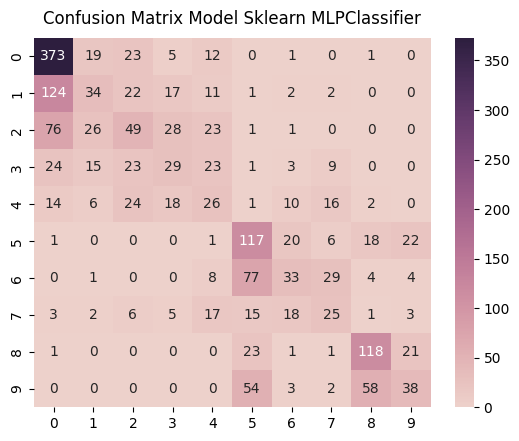

,precision,recall,f1-score,support
0.0,0.605519,0.859447,0.710476,434.000000
1.0,0.330097,0.159624,0.215190,213.000000
2.0,0.333333,0.240196,0.279202,204.000000
3.0,0.284314,0.228346,0.253275,127.000000
4.0,0.214876,0.222222,0.218487,117.000000
5.0,0.403448,0.632432,0.492632,185.000000
6.0,0.358696,0.211538,0.266129,156.000000
7.0,0.277778,0.263158,0.270270,95.000000
8.0,0.584158,0.715152,0.643052,165.000000
9.0,0.431818,0.245161,0.312757,155.000000


In [156]:
predict = model.predict(x_test)

confusion_matrix_result = confusion_matrix(y_test, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_test, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

**Train Predictions**

58/58 [==============================] - 0s 2ms/step


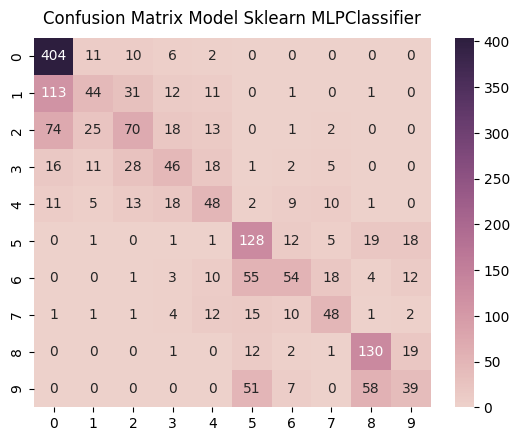

,precision,recall,f1-score,support
0.0,0.652666,0.933025,0.768061,433.000000
1.0,0.448980,0.206573,0.282958,213.000000
2.0,0.454545,0.344828,0.392157,203.000000
3.0,0.422018,0.362205,0.389831,127.000000
4.0,0.417391,0.410256,0.413793,117.000000
5.0,0.484848,0.691892,0.570156,185.000000
6.0,0.551020,0.343949,0.423529,157.000000
7.0,0.539326,0.505263,0.521739,95.000000
8.0,0.607477,0.787879,0.686016,165.000000
9.0,0.433333,0.251613,0.318367,155.000000


In [157]:
predict = model.predict(x_train)

confusion_matrix_result = confusion_matrix(y_train, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_train, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()


## Epoch 50

Epoch 1/50
58/58 [==============================] - 1s 4ms/step - loss: 2.2297 - accuracy: 0.2319
Epoch 2/50
58/58 [==============================] - 0s 4ms/step - loss: 2.1145 - accuracy: 0.2503
Epoch 3/50
58/58 [==============================] - 0s 4ms/step - loss: 1.9087 - accuracy: 0.3227
Epoch 4/50
58/58 [==============================] - 0s 4ms/step - loss: 1.7454 - accuracy: 0.3405
Epoch 5/50
58/58 [==============================] - 0s 4ms/step - loss: 1.6524 - accuracy: 0.3422
Epoch 6/50
58/58 [==============================] - 0s 4ms/step - loss: 1.5944 - accuracy: 0.3573
Epoch 7/50
58/58 [==============================] - 0s 3ms/step - loss: 1.5508 - accuracy: 0.3816
Epoch 8/50
58/58 [==============================] - 0s 2ms/step - loss: 1.5113 - accuracy: 0.4157
Epoch 9/50
58/58 [==============================] - 0s 2ms/step - loss: 1.4772 - accuracy: 0.4211
Epoch 10/50
58/58 [==============================] - 0s 3ms/step - loss: 1.4489 - accuracy: 0.4357
Epoch 11/50
58/58 [

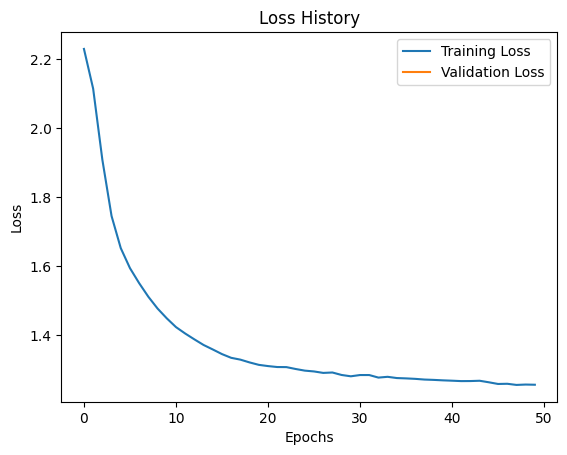

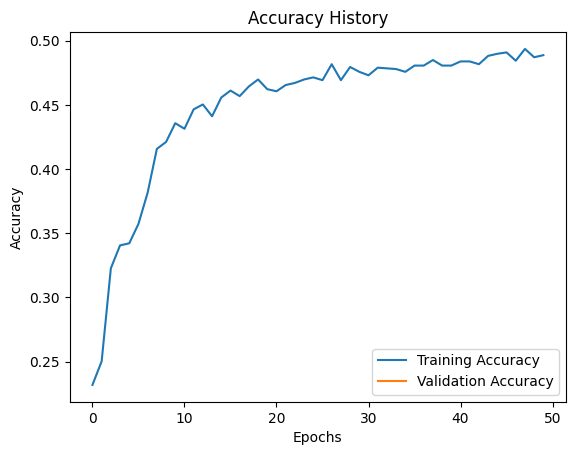

58/58 [==============================] - 0s 2ms/step - loss: 1.2454 - accuracy: 0.4941

Test Accuracy	: 0.46569421887397766
Train Accuracy	: 0.49405404925346375


In [158]:
model = MLPClassifier(x_train.shape[1], label.unique().shape[0], learning_rate=0.001, activation_function='sigmoid')

history = model.set_history()
model.train(x_train, y_train, epochs=50, callback=history, batch_size=32)

model.plot_loss_history(history.losses, history.val_losses)
model.plot_accuracy_history(history.accuracies, history.val_accuracies)
print(f'\nTest Accuracy\t: {model.get_accuracy(x_test, y_test)}\nTrain Accuracy\t: {model.get_accuracy(x_train, y_train)}')

### Classification Report

In [159]:
def plot_cm(matrix, title):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=sns.cubehelix_palette(as_cmap=True))

    ax.set_title(f'Confusion Matrix {title}', pad=10);
    plt.show()

**Test Predictions**

58/58 [==============================] - 0s 2ms/step


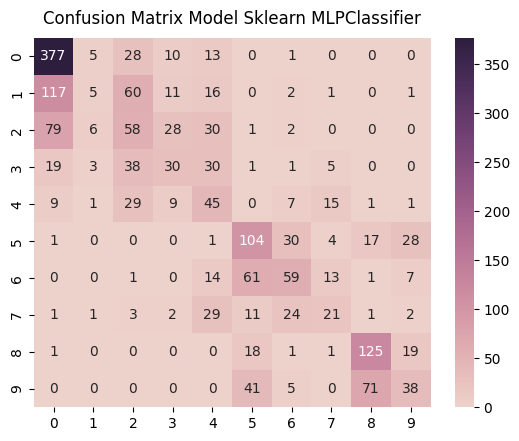

,precision,recall,f1-score,support
0.0,0.624172,0.868664,0.726397,434.000000
1.0,0.238095,0.023474,0.042735,213.000000
2.0,0.267281,0.284314,0.275534,204.000000
3.0,0.333333,0.236220,0.276498,127.000000
4.0,0.252809,0.384615,0.305085,117.000000
5.0,0.438819,0.562162,0.492891,185.000000
6.0,0.446970,0.378205,0.409722,156.000000
7.0,0.350000,0.221053,0.270968,95.000000
8.0,0.578704,0.757576,0.656168,165.000000
9.0,0.395833,0.245161,0.302789,155.000000


In [160]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_test)

confusion_matrix_result = confusion_matrix(y_test, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_test, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

**Train Predictions**

58/58 [==============================] - 0s 2ms/step


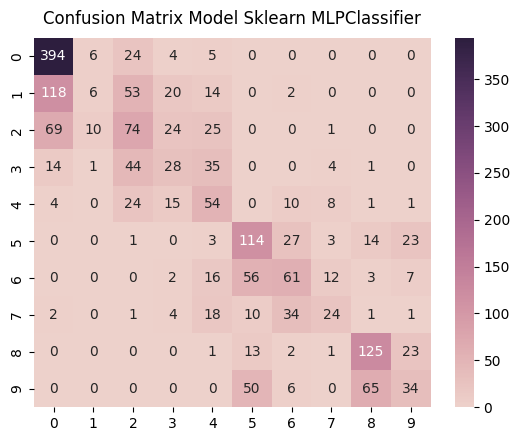

,precision,recall,f1-score,support
0.0,0.655574,0.909931,0.762089,433.000000
1.0,0.260870,0.028169,0.050847,213.000000
2.0,0.334842,0.364532,0.349057,203.000000
3.0,0.288660,0.220472,0.250000,127.000000
4.0,0.315789,0.461538,0.375000,117.000000
5.0,0.469136,0.616216,0.532710,185.000000
6.0,0.429577,0.388535,0.408027,157.000000
7.0,0.452830,0.252632,0.324324,95.000000
8.0,0.595238,0.757576,0.666667,165.000000
9.0,0.382022,0.219355,0.278689,155.000000


In [161]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_train)

confusion_matrix_result = confusion_matrix(y_train, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_train, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

## Epoch 100

Epoch 1/100
58/58 [==============================] - 1s 3ms/step - loss: 2.2297 - accuracy: 0.2319
Epoch 2/100
58/58 [==============================] - 0s 2ms/step - loss: 2.1145 - accuracy: 0.2503
Epoch 3/100
58/58 [==============================] - 0s 2ms/step - loss: 1.9087 - accuracy: 0.3227
Epoch 4/100
58/58 [==============================] - 0s 3ms/step - loss: 1.7454 - accuracy: 0.3405
Epoch 5/100
58/58 [==============================] - 0s 2ms/step - loss: 1.6524 - accuracy: 0.3422
Epoch 6/100
58/58 [==============================] - 0s 3ms/step - loss: 1.5944 - accuracy: 0.3573
Epoch 7/100
58/58 [==============================] - 0s 2ms/step - loss: 1.5508 - accuracy: 0.3816
Epoch 8/100
58/58 [==============================] - 0s 2ms/step - loss: 1.5113 - accuracy: 0.4157
Epoch 9/100
58/58 [==============================] - 0s 2ms/step - loss: 1.4772 - accuracy: 0.4211
Epoch 10/100
58/58 [==============================] - 0s 2ms/step - loss: 1.4489 - accuracy: 0.4357
Epoch 11/

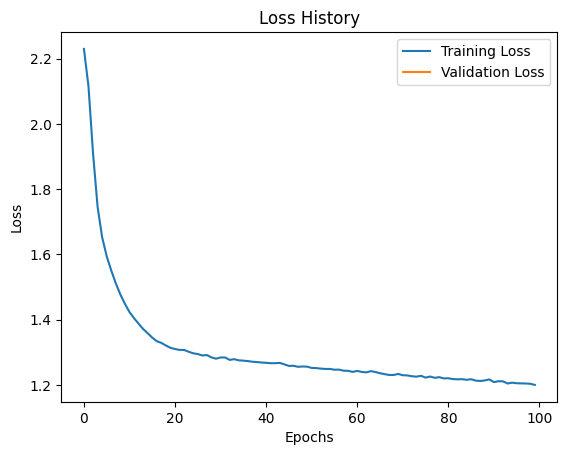

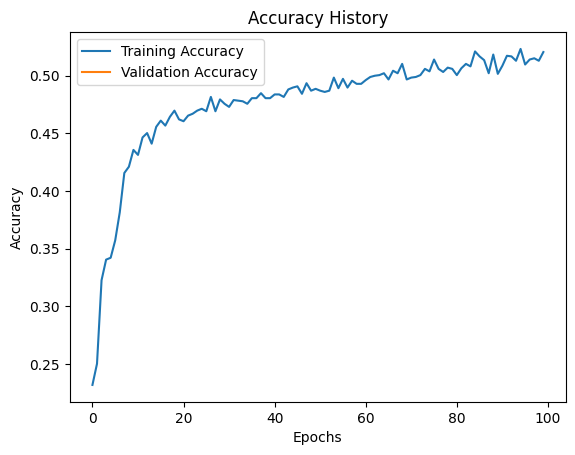

58/58 [==============================] - 0s 2ms/step - loss: 1.1900 - accuracy: 0.5130

Test Accuracy	: 0.45218801498413086
Train Accuracy	: 0.5129729509353638


In [162]:
model = MLPClassifier(x_train.shape[1], label.unique().shape[0], learning_rate=0.001, activation_function='sigmoid')

history = model.set_history()
model.train(x_train, y_train, epochs=100, callback=history, batch_size=32)

model.plot_loss_history(history.losses, history.val_losses)
model.plot_accuracy_history(history.accuracies, history.val_accuracies)
print(f'\nTest Accuracy\t: {model.get_accuracy(x_test, y_test)}\nTrain Accuracy\t: {model.get_accuracy(x_train, y_train)}')

### Classification Report

In [163]:
def plot_cm(matrix, title):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=sns.cubehelix_palette(as_cmap=True))

    ax.set_title(f'Confusion Matrix {title}', pad=10);
    plt.show()

**Test Predictions**

58/58 [==============================] - 0s 1ms/step


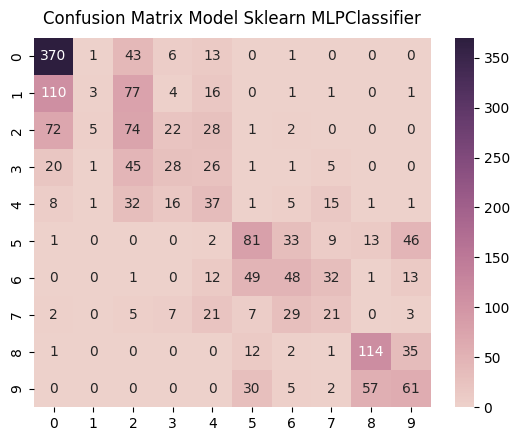

,precision,recall,f1-score,support
0.0,0.633562,0.852535,0.726916,434.000000
1.0,0.272727,0.014085,0.026786,213.000000
2.0,0.267148,0.362745,0.307692,204.000000
3.0,0.337349,0.220472,0.266667,127.000000
4.0,0.238710,0.316239,0.272059,117.000000
5.0,0.445055,0.437838,0.441417,185.000000
6.0,0.377953,0.307692,0.339223,156.000000
7.0,0.244186,0.221053,0.232044,95.000000
8.0,0.612903,0.690909,0.649573,165.000000
9.0,0.381250,0.393548,0.387302,155.000000


In [164]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_test)

confusion_matrix_result = confusion_matrix(y_test, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_test, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

**Train Predictions**

58/58 [==============================] - 0s 2ms/step


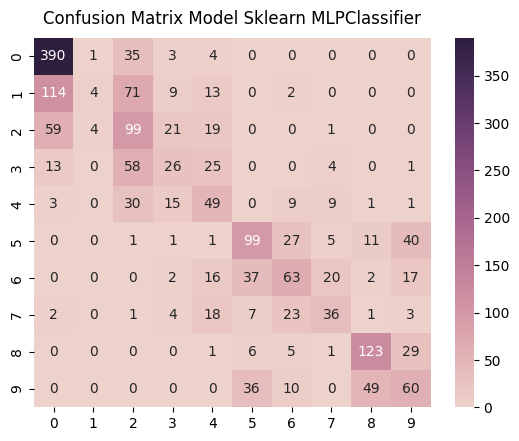

,precision,recall,f1-score,support
0.0,0.671256,0.900693,0.769231,433.000000
1.0,0.444444,0.018779,0.036036,213.000000
2.0,0.335593,0.487685,0.397590,203.000000
3.0,0.320988,0.204724,0.250000,127.000000
4.0,0.335616,0.418803,0.372624,117.000000
5.0,0.535135,0.535135,0.535135,185.000000
6.0,0.453237,0.401274,0.425676,157.000000
7.0,0.473684,0.378947,0.421053,95.000000
8.0,0.657754,0.745455,0.698864,165.000000
9.0,0.397351,0.387097,0.392157,155.000000


In [165]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_train)

confusion_matrix_result = confusion_matrix(y_train, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_train, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

## Epoch 500

Epoch 1/500
58/58 [==============================] - 1s 4ms/step - loss: 2.2297 - accuracy: 0.2319
Epoch 2/500
58/58 [==============================] - 0s 4ms/step - loss: 2.1145 - accuracy: 0.2503
Epoch 3/500
58/58 [==============================] - 0s 4ms/step - loss: 1.9087 - accuracy: 0.3227
Epoch 4/500
58/58 [==============================] - 0s 4ms/step - loss: 1.7454 - accuracy: 0.3405
Epoch 5/500
58/58 [==============================] - 0s 4ms/step - loss: 1.6524 - accuracy: 0.3422
Epoch 6/500
58/58 [==============================] - 0s 4ms/step - loss: 1.5944 - accuracy: 0.3573
Epoch 7/500
58/58 [==============================] - 0s 3ms/step - loss: 1.5508 - accuracy: 0.3816
Epoch 8/500
58/58 [==============================] - 0s 3ms/step - loss: 1.5113 - accuracy: 0.4157
Epoch 9/500
58/58 [==============================] - 0s 2ms/step - loss: 1.4772 - accuracy: 0.4211
Epoch 10/500
58/58 [==============================] - 0s 2ms/step - loss: 1.4489 - accuracy: 0.4357
Epoch 11/

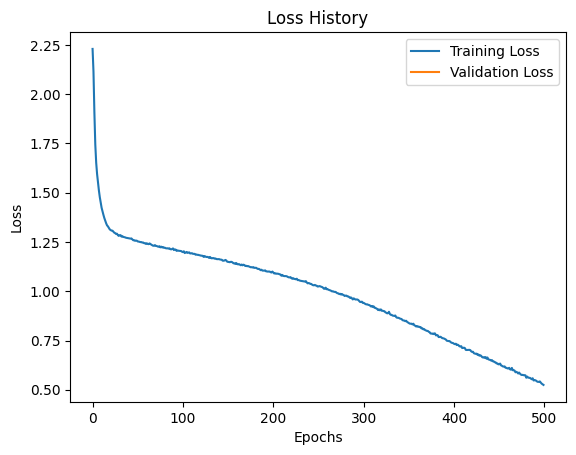

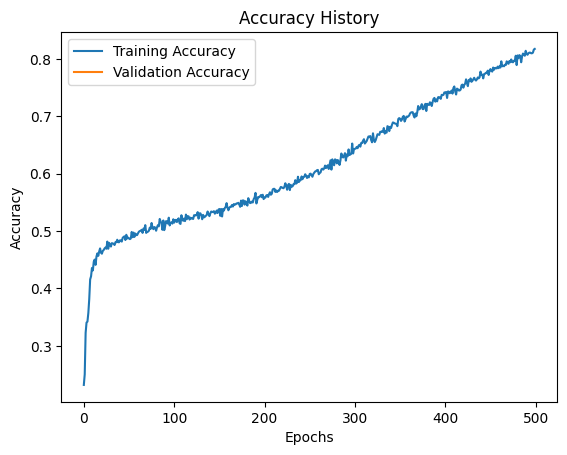

58/58 [==============================] - 0s 2ms/step - loss: 0.5129 - accuracy: 0.8232

Test Accuracy	: 0.3960021734237671
Train Accuracy	: 0.823243260383606


In [166]:
model = MLPClassifier(x_train.shape[1], label.unique().shape[0], learning_rate=0.001, activation_function='sigmoid')

history = model.set_history()
model.train(x_train, y_train, epochs=500, callback=history, batch_size=32)

model.plot_loss_history(history.losses, history.val_losses)
model.plot_accuracy_history(history.accuracies, history.val_accuracies)
print(f'\nTest Accuracy\t: {model.get_accuracy(x_test, y_test)}\nTrain Accuracy\t: {model.get_accuracy(x_train, y_train)}')

### Classification Report

In [167]:
def plot_cm(matrix, title):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=sns.cubehelix_palette(as_cmap=True))

    ax.set_title(f'Confusion Matrix {title}', pad=10);
    plt.show()

**Test Predictions**

58/58 [==============================] - 0s 2ms/step


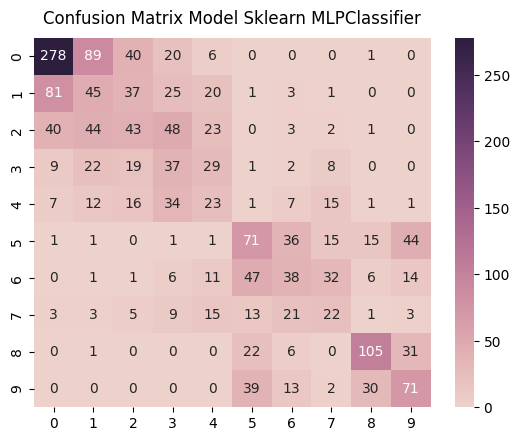

,precision,recall,f1-score,support
0.0,0.663484,0.640553,0.651817,434.000000
1.0,0.206422,0.211268,0.208817,213.000000
2.0,0.267081,0.210784,0.235616,204.000000
3.0,0.205556,0.291339,0.241042,127.000000
4.0,0.179688,0.196581,0.187755,117.000000
5.0,0.364103,0.383784,0.373684,185.000000
6.0,0.294574,0.243590,0.266667,156.000000
7.0,0.226804,0.231579,0.229167,95.000000
8.0,0.656250,0.636364,0.646154,165.000000
9.0,0.432927,0.458065,0.445141,155.000000


In [168]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_test)

confusion_matrix_result = confusion_matrix(y_test, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_test, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

**Train Predictions**

58/58 [==============================] - 0s 2ms/step


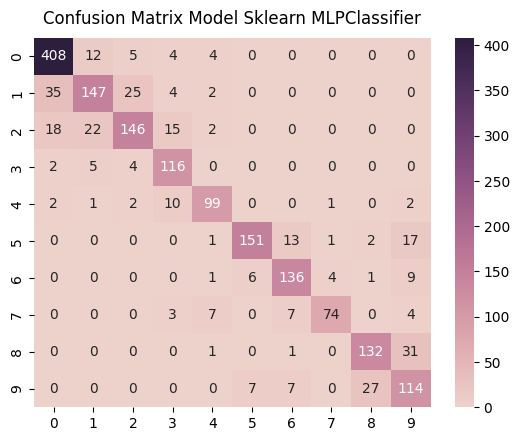

,precision,recall,f1-score,support
0.0,0.877419,0.942263,0.908686,433.000000
1.0,0.786096,0.690141,0.735000,213.000000
2.0,0.802198,0.719212,0.758442,203.000000
3.0,0.763158,0.913386,0.831541,127.000000
4.0,0.846154,0.846154,0.846154,117.000000
5.0,0.920732,0.816216,0.865330,185.000000
6.0,0.829268,0.866242,0.847352,157.000000
7.0,0.925000,0.778947,0.845714,95.000000
8.0,0.814815,0.800000,0.807339,165.000000
9.0,0.644068,0.735484,0.686747,155.000000


In [169]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_train)

confusion_matrix_result = confusion_matrix(y_train, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_train, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

## Epoch 1000

Epoch 1/1000
58/58 [==============================] - 1s 3ms/step - loss: 2.2297 - accuracy: 0.2319
Epoch 2/1000
58/58 [==============================] - 0s 3ms/step - loss: 2.1145 - accuracy: 0.2503
Epoch 3/1000
58/58 [==============================] - 0s 2ms/step - loss: 1.9087 - accuracy: 0.3227
Epoch 4/1000
58/58 [==============================] - 0s 2ms/step - loss: 1.7454 - accuracy: 0.3405
Epoch 5/1000
58/58 [==============================] - 0s 2ms/step - loss: 1.6524 - accuracy: 0.3422
Epoch 6/1000
58/58 [==============================] - 0s 2ms/step - loss: 1.5944 - accuracy: 0.3573
Epoch 7/1000
58/58 [==============================] - 0s 2ms/step - loss: 1.5508 - accuracy: 0.3816
Epoch 8/1000
58/58 [==============================] - 0s 2ms/step - loss: 1.5113 - accuracy: 0.4157
Epoch 9/1000
58/58 [==============================] - 0s 2ms/step - loss: 1.4772 - accuracy: 0.4211
Epoch 10/1000
58/58 [==============================] - 0s 2ms/step - loss: 1.4489 - accuracy: 0.4357

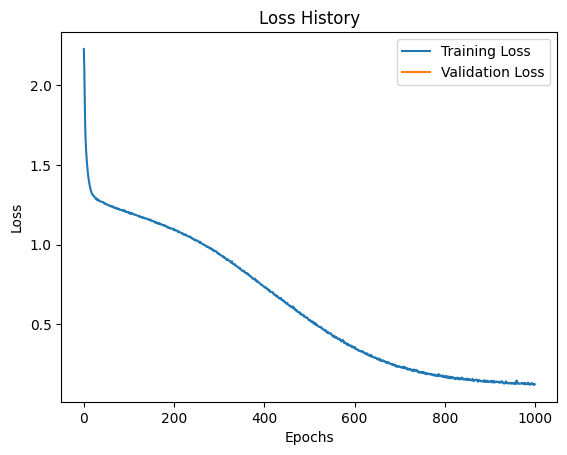

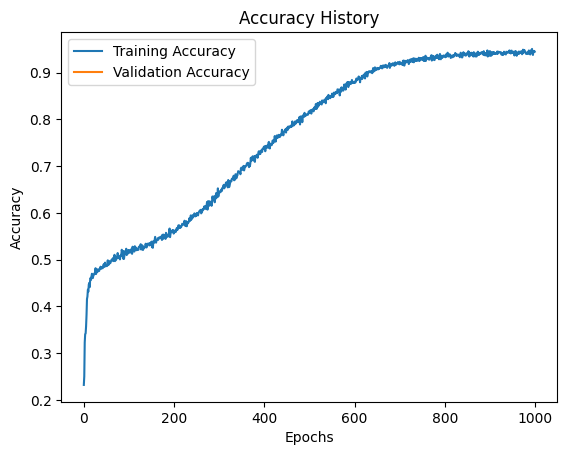

58/58 [==============================] - 0s 2ms/step - loss: 0.1113 - accuracy: 0.9535

Test Accuracy	: 0.3641274869441986
Train Accuracy	: 0.953513503074646


In [170]:
model = MLPClassifier(x_train.shape[1], label.unique().shape[0], learning_rate=0.001, activation_function='sigmoid')

history = model.set_history()
model.train(x_train, y_train, epochs=1000, callback=history, batch_size=32)

model.plot_loss_history(history.losses, history.val_losses)
model.plot_accuracy_history(history.accuracies, history.val_accuracies)
print(f'\nTest Accuracy\t: {model.get_accuracy(x_test, y_test)}\nTrain Accuracy\t: {model.get_accuracy(x_train, y_train)}')

### Classification Report

In [171]:
def plot_cm(matrix, title):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=sns.cubehelix_palette(as_cmap=True))

    ax.set_title(f'Confusion Matrix {title}', pad=10);
    plt.show()

**Test Predictions**

58/58 [==============================] - 0s 2ms/step


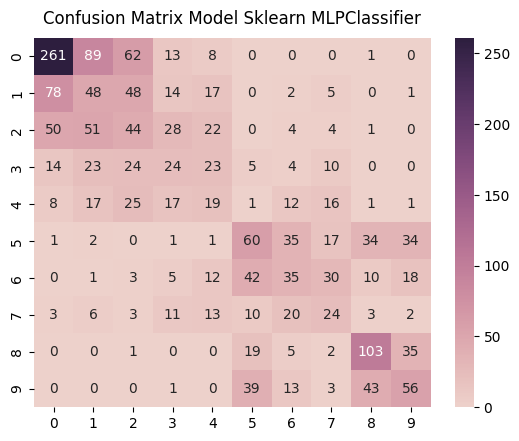

,precision,recall,f1-score,support
0.0,0.628916,0.601382,0.614841,434.000000
1.0,0.202532,0.225352,0.213333,213.000000
2.0,0.209524,0.215686,0.212560,204.000000
3.0,0.210526,0.188976,0.199170,127.000000
4.0,0.165217,0.162393,0.163793,117.000000
5.0,0.340909,0.324324,0.332410,185.000000
6.0,0.269231,0.224359,0.244755,156.000000
7.0,0.216216,0.252632,0.233010,95.000000
8.0,0.525510,0.624242,0.570637,165.000000
9.0,0.380952,0.361290,0.370861,155.000000


In [172]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_test)

confusion_matrix_result = confusion_matrix(y_test, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_test, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()

**Train Predictions**

58/58 [==============================] - 0s 2ms/step


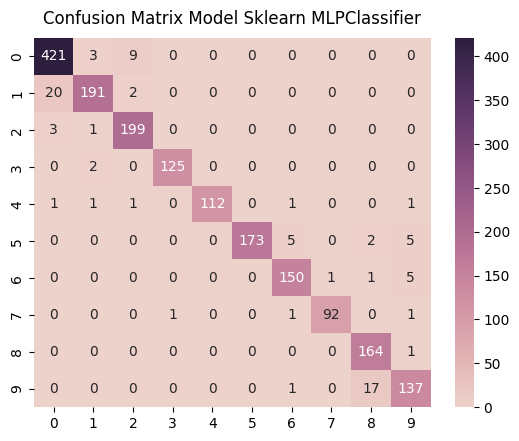

,precision,recall,f1-score,support
0.0,0.946067,0.972286,0.958998,433.000000
1.0,0.964646,0.896714,0.929440,213.000000
2.0,0.943128,0.980296,0.961353,203.000000
3.0,0.992063,0.984252,0.988142,127.000000
4.0,1.000000,0.957265,0.978166,117.000000
5.0,1.000000,0.935135,0.966480,185.000000
6.0,0.949367,0.955414,0.952381,157.000000
7.0,0.989247,0.968421,0.978723,95.000000
8.0,0.891304,0.993939,0.939828,165.000000
9.0,0.913333,0.883871,0.898361,155.000000


In [173]:
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(x_train)

confusion_matrix_result = confusion_matrix(y_train, predict)
plot_cm(confusion_matrix_result, 'Model Sklearn MLPClassifier')

model_report = classification_report(y_train, predict, output_dict=True, zero_division=0)
pd.DataFrame(model_report).transpose()